<a href="https://colab.research.google.com/github/Sirfowahid/Bangla_Contextual_Analysis/blob/main/Aspect_Based_Contextual_Analysis_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
df = pd.read_excel('/content/drive/MyDrive/Projects/02. Contextual Analysis With Book Review Dataset/Book Review Aspect final.xlsx')
df.head()

,id,Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,Comment About,Unnamed: 10
0,89,নামাজ আদায়ের সঠিক পদ্ধতি,حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,সালাত/নামায,2,কিছু পৃষ্ঠা ফাঁকা,Rokomari,negative,0,NaN,0
1,1,ছহীহ নূরানী বাংলা উচ্চারণ সহজ সরল বঙ্গানুবাদ ও...,মাওলানা ফরিদ উদ্দিন আহাম্মদ (অনুবাদক),নূরানী কুরআন,1,প্রত্যাশার নীচে কাগজের গুণমান,Rokomari,negative,0,NaN,0
2,195,ইসলামের দৃষ্টিতে পর্দার হুকুম ও নারীর মর্যাদা ...,حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,পর্দা বিধান,1,সোলেমানীয়া বুক হাউস প্রকাশনীর সব বই গুলিতে প্র...,Rokomari,negative,0,NaN,0
3,343,আশরাফ আলি থানভির প্রিয়গল্প-২ (হার্ডকভার),حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,ইসলামি গল্প,1,"বইয়ের কাভার আর সূচিপত্র প্রিয়গল্প-২, ভিতরে প্র...",Rokomari,negative,0,NaN,0
4,465,ছড়ায় ছন্দে চিড়িয়াখানা (প্রাণী) (হার্ডকভার) ছো...,ইয়াছিন আরাফাত,বয়স যখন ৪-৮: বাংলা ছড়া,2,"কালার , পেজ, লেখার কুয়ালিটি খুবই নিম্ন মানের ,...",Rokomari,negative,0,NaN,0


In [6]:
df.columns

Index(['id', 'Name', 'Writer_Name', 'Category', 'Rating', 'Review', 'Site',
       'sentiment', 'label', 'Comment About', 'Unnamed: 10'],
      dtype='object')

In [7]:
df.tail(10)

,id,Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,Comment About,Unnamed: 10
2044,38668,সোফির জগৎ (হার্ডকভার) আন্তর্জাতিক পুরস্কার প...,ইয়স্তেন গার্ডার,পাশ্চাত্য দর্শন,3,ভালো,Rokomari,neutral,1,NaN,1
2045,38686,সোফির জগৎ (হার্ডকভার) পাশ্চাত্য দর্শনের সংক্ষ...,ইয়স্তেন গার্ডার,অনুবাদ উপন্যাস,3,ভালো,Rokomari,neutral,1,NaN,1
2046,38760,আরজ আলীর রম্য (হার্ডকভার),ইয়াছির মিশুক,ব্যঙ্গ ও রম্যরচনা,3,আমি বইটা কিনার সময় প্রথমে ভেবেছিলাম এটা প্যারা...,Rokomari,neutral,1,NaN,1
2047,38806,জেমস বন্ড সমগ্র (হার্ডকভার),ইয়ান ফ্লেমিং,"রহস্য, গোয়েন্দা, ভৌতিক, মিথ, থ্রিলার, ও অ্যাড...",3,সুন্দর বই,Rokomari,neutral,1,NaN,1
2048,38887,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,যতটা আশা নিয়ে বইটি কিনেছিলাম আসলেই সেটা সে রকম...,Rokomari,neutral,1,NaN,1
2049,38891,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,এই বইগুলি ভাল।,Rokomari,neutral,1,NaN,1
2050,38892,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,ভাল,Rokomari,neutral,1,NaN,1
2051,38906,নিলামে পাঁচটি শব্দ,ইয়াসির মনন,সমকালীন গল্প,3,ছোটগল্প! আকারে ছোট। গল্প বিস্তার কম...কথা সহজ ...,Rokomari,neutral,1,NaN,1
2052,38979,Dipu Number Two (Hardcover),Muhammod Zafar Iqbal,Novel: Children and Teens,3,বইটির প্রধান চরিত্র দিপু। সবাই তাকে চেনে দিপু ...,Rokomari,neutral,1,NaN,1
2053,38988,"মাইন্ড ওয়ারস (পেপারব্যাক) সরকার, মিডিয়া ও গো...",ম্যারি ডি. জনস,"ডিটেকটিভ, ইন্টেলিজেন্স ও সিক্রেট এজেন্সি",3,অনুবাদ যথেষ্ট ভাল না।,Rokomari,neutral,1,NaN,1


In [8]:
df_mod = df[['Review','label']].dropna()

In [9]:
df_mod.describe()

,Review,label
count,2054,2054
unique,1604,4
top,ভাল,0
freq,87,1123


In [10]:
df_mod.label.unique()

array([0, 2, 1, '  '], dtype=object)

In [11]:
df_mod[df['label']=='  ']

,Review,label
634,ঠিক আছে,


In [12]:
df_mod.drop(index=634,inplace=True)

In [13]:
df_mod.label.unique()

array([0, 2, 1], dtype=object)

<Axes: >

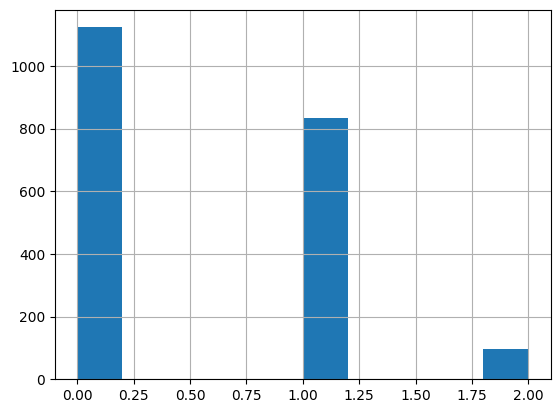

In [14]:
df_mod.label.hist()

In [15]:
new_df = pd.get_dummies(df_mod['label'])

<ipython-input-15-0208dea10a3b>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_df = pd.get_dummies(df_mod['label'])


In [16]:
new_df.head()

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [17]:
new_df['Review'] = df_mod['Review']

In [18]:
new_df.tail(10)

,0,1,2,Review
2044,0,1,0,ভালো
2045,0,1,0,ভালো
2046,0,1,0,আমি বইটা কিনার সময় প্রথমে ভেবেছিলাম এটা প্যারা...
2047,0,1,0,সুন্দর বই
2048,0,1,0,যতটা আশা নিয়ে বইটি কিনেছিলাম আসলেই সেটা সে রকম...
2049,0,1,0,এই বইগুলি ভাল।
2050,0,1,0,ভাল
2051,0,1,0,ছোটগল্প! আকারে ছোট। গল্প বিস্তার কম...কথা সহজ ...
2052,0,1,0,বইটির প্রধান চরিত্র দিপু। সবাই তাকে চেনে দিপু ...
2053,0,1,0,অনুবাদ যথেষ্ট ভাল না।


In [19]:
new_df['Label'] = new_df[new_df.columns[:3]].values.tolist()

In [20]:
new_df.head()

,0,1,2,Review,Label
0,1,0,0,কিছু পৃষ্ঠা ফাঁকা,"[1, 0, 0]"
1,1,0,0,প্রত্যাশার নীচে কাগজের গুণমান,"[1, 0, 0]"
2,1,0,0,সোলেমানীয়া বুক হাউস প্রকাশনীর সব বই গুলিতে প্র...,"[1, 0, 0]"
3,1,0,0,"বইয়ের কাভার আর সূচিপত্র প্রিয়গল্প-২, ভিতরে প্র...","[1, 0, 0]"
4,1,0,0,"কালার , পেজ, লেখার কুয়ালিটি খুবই নিম্ন মানের ,...","[1, 0, 0]"


In [21]:
 new_df = new_df[['Review','Label']]

In [22]:
new_df.head()

,Review,Label
0,কিছু পৃষ্ঠা ফাঁকা,"[1, 0, 0]"
1,প্রত্যাশার নীচে কাগজের গুণমান,"[1, 0, 0]"
2,সোলেমানীয়া বুক হাউস প্রকাশনীর সব বই গুলিতে প্র...,"[1, 0, 0]"
3,"বইয়ের কাভার আর সূচিপত্র প্রিয়গল্প-২, ভিতরে প্র...","[1, 0, 0]"
4,"কালার , পেজ, লেখার কুয়ালিটি খুবই নিম্ন মানের ,...","[1, 0, 0]"


In [23]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Review
        self.targets = self.data.Label
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [25]:

train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (2053, 2)
TRAIN Dataset: (1642, 2)
TEST Dataset: (411, 2)


In [26]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [27]:

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr